# Day4. Backpropagation


---

본 과제에서는 경사하강법(Gradient Descent)으로 모델 학습 할 때 사용하는 알고리즘인 역전파(backpropagation)를 구현해보도록 하겠습니다.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

## Recap
2강 실습에서는 아래와 같이 torch 모듈(**backward( ), step( ) 등**)을 활용하여 backpropagation을 구현해 gradient를 구하고 모델을 업데이트 했습니다.

이번 실습에서는 해당 과정을 torch 모듈을 사용하지 않고 구현해볼겁니다.

In [2]:
# 샘플 데이터 생성
x_data = [[1, -4], [1, 2], [2, 3], [3, 1],[4, -2], [4, 3], [5, 3], [6, 2], [3, 8], [6, -2]]
y_data = [[0], [0], [0], [0], [0], [1], [1], [1], [1], [1]]
x_train = torch.FloatTensor(x_data)
y_train = torch.FloatTensor(y_data)

In [3]:
# 모델 초기화
W = torch.zeros((2,1), requires_grad = True)
b = torch.zeros(1, requires_grad = True)

# optimizer 설정
optimizer = optim.Adam([W,b], lr = 0.01)

nb_epochs = 5000
for epoch in range(nb_epochs + 1):

    # [Do it yourself] hypothesis 계산
    hypothesis = 1 / (1 + torch.exp(-(x_train.matmul(W) + b)))

    # [Do it yourself] Cost 계산
    cost = -(y_train * torch.log(hypothesis) + (1 - y_train) * torch.log(1 - hypothesis)).mean()

    # [Do it yourself] optimizer와 cost를 이용해 모델 파라메터 W,b를 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 100번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(epoch, nb_epochs, cost.item()))

Epoch    0/5000 Cost: 0.693147
Epoch  100/5000 Cost: 0.442445
Epoch  200/5000 Cost: 0.351426
Epoch  300/5000 Cost: 0.289290
Epoch  400/5000 Cost: 0.244120
Epoch  500/5000 Cost: 0.209718
Epoch  600/5000 Cost: 0.182610
Epoch  700/5000 Cost: 0.160700
Epoch  800/5000 Cost: 0.142635
Epoch  900/5000 Cost: 0.127506
Epoch 1000/5000 Cost: 0.114669
Epoch 1100/5000 Cost: 0.103659
Epoch 1200/5000 Cost: 0.094128
Epoch 1300/5000 Cost: 0.085813
Epoch 1400/5000 Cost: 0.078507
Epoch 1500/5000 Cost: 0.072048
Epoch 1600/5000 Cost: 0.066308
Epoch 1700/5000 Cost: 0.061179
Epoch 1800/5000 Cost: 0.056578
Epoch 1900/5000 Cost: 0.052433
Epoch 2000/5000 Cost: 0.048685
Epoch 2100/5000 Cost: 0.045285
Epoch 2200/5000 Cost: 0.042190
Epoch 2300/5000 Cost: 0.039366
Epoch 2400/5000 Cost: 0.036781
Epoch 2500/5000 Cost: 0.034410
Epoch 2600/5000 Cost: 0.032230
Epoch 2700/5000 Cost: 0.030221
Epoch 2800/5000 Cost: 0.028366
Epoch 2900/5000 Cost: 0.026650
Epoch 3000/5000 Cost: 0.025061
Epoch 3100/5000 Cost: 0.023585
Epoch 32

## Gradient Descent with Multi-Layer Perceptron
MLP 모델 클래스를 구현합니다.  

해당 클래스는 다음 두 주요 함수로 구성됩니다.
1. 데이터를 입력 받아 출력을 내는  **feed_forward** 함수  

2. **feed_forward** 함수로 예측값을 출력하고 이와 정답 사이의 차이(loss)로 부터 weight update를 위한 backpropation과 gradient descent를 수행하는 **back_propagate** 함수

클래스 구조와 주석을 자세히 살펴보면서, TODO를 구현해주세요!

In [4]:
class MLP(object):

    def _identity(x):

        return x

    def _sigmoid(x):

        return 1/(1+np.power(np.e, -x))

    def _gradient_sigmoid(x):

        tmp = MLP._sigmoid(x)

        return tmp*(1-tmp)

    def __init__(self, layers):

        self.layers = layers # 각 layer에 차원을 저장한 List
        self.activate = [MLP._identity]
        self.weights = [1]
        self.lr = 0.002

        # layer 쌓아서 MLP 네트워크 구성
        for i in range(1, len(self.layers)):
            self.weights.append(np.random.normal(0, 0.5, (self.layers[i-1], self.layers[i])))

            # 마지막 layer는 sigmoid activation 대신 identity mapping
            if i != len(self.layers)-1:

                self.activate.append(MLP._sigmoid)

            else:

                self.activate.append(MLP._identity)

    def feed_forward(self, x):

        self.S = [x]
        self.Z = [x]

        for i in range(1, len(self.layers)):

            s = self.Z[i-1].dot(self.weights[i]) # hint, s = Wx
            z = self.activate[i](s) # z = activation(s)

            # backpropagation 때 사용할 값들 forward pass에서 list로 저장
            self.S.append(s)
            self.Z.append(z)

        return self.Z[-1]

    def back_propagate(self, x, y):

        pred_y = self.feed_forward(x)
        self.upstream_gradient_list = []

        for i in reversed(range(1, len(self.layers))):

            if i == len(self.layers)-1:

                upstream_gradient = pred_y - y # 마지막 layer(loss를 backpropa)

            else:

                upstream_gradient = MLP._gradient_sigmoid(self.S[i])*(self.upstream_gradient_list[-1].dot(self.weights[i+1].T))

            dW = self.Z[i-1].T.dot(upstream_gradient) # Hint, Z: W에 대한 local gradient

            self.weights[i] -= self.lr*dW # gradient descent로 웨이트 업데이트

            self.upstream_gradient_list.append(upstream_gradient)  # upstream gradient를 앞으로 내려보내기 위한 list

        return

    def evaluate(self, xs, ys):

        pred_ys = self.feed_forward(xs)
        d = pred_ys - ys
        return np.mean(np.sqrt(d**2))


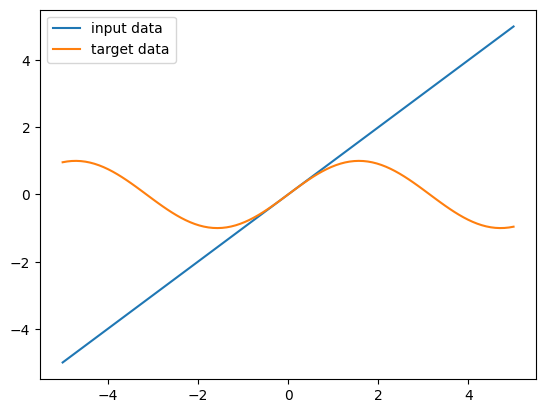

In [5]:
# 입력/정답 데이터 선언
train_x = np.linspace(-5, 5, 100).reshape(-1, 1)
train_y = np.sin(train_x).reshape(-1, 1)

# 학습 전 입력이 정답 시각화 해보기
plt.plot(train_x.ravel(), train_x.ravel(), label = 'input data')
plt.plot(train_x.ravel(), train_y.ravel(), label = 'target data')
plt.legend()

In [6]:
# 모델 선언
model = MLP(layers = [1,5,5,5,1])

# 모델 학습: forward -> backward -> update 반복
num_iter = 100000
errors_full = []
for i in range(num_iter):
    model.back_propagate(train_x, train_y) #안에 feed_forward가 실행됨

    # 100 step 마다 loss 확인
    if (i+1) % 5000 == 0:
        error = model.evaluate(train_x, train_y)
        print('ITER={:05d}, RMSE={:.4f}'.format(i+1, error))
        errors_full.append(error)

ITER=05000, RMSE=0.6362
ITER=10000, RMSE=0.6346
ITER=15000, RMSE=0.6341
ITER=20000, RMSE=0.6337
ITER=25000, RMSE=0.6334
ITER=30000, RMSE=0.6331
ITER=35000, RMSE=0.6326
ITER=40000, RMSE=0.6302
ITER=45000, RMSE=0.1714
ITER=50000, RMSE=0.1361
ITER=55000, RMSE=0.1194
ITER=60000, RMSE=0.1094
ITER=65000, RMSE=0.1022
ITER=70000, RMSE=0.0961
ITER=75000, RMSE=0.0909
ITER=80000, RMSE=0.0862
ITER=85000, RMSE=0.0818
ITER=90000, RMSE=0.0774
ITER=95000, RMSE=0.0737
ITER=100000, RMSE=0.0711


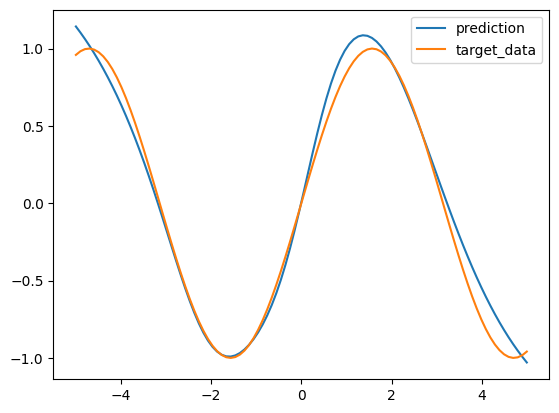

In [7]:
# 학습 후 입력이 정답에 얼마나 가까워 졌는지 시각화 해보기
pred_ys = model.feed_forward(train_x)

plt.plot(train_x.ravel(), pred_ys.ravel(), label = 'prediction')
plt.plot(train_x.ravel(), train_y.ravel(), label = 'target_data')
plt.legend()

## Stochastic Gradient Descent


- 위 예제를 바탕으로 기존 Data로부터 mini-batch를 구성해서 Gradient Descent를 진행해주시면 됩니다.
- mini-batch의 경우 입력과 타겟 데이터를 concat 한 뒤, **np.random.shuffle**, **np.split** 함수를 활용해서 10개를 하나의 batch로 학습에 사용합니다.

In [8]:
# 데이터 선언
train_x = np.linspace(-5,5,100).reshape(-1,1)
train_y = np.sin(train_x).reshape(-1,1)

concat = np.concatenate([train_x, train_y],axis = 1)

# 모델 선언
model = MLP(layers = [1,5,5,5,1])

# 모델 학습: forward -> backward -> update 반복
num_iter = 100000
errors_stochastic = []
for i in range(num_iter):

    # mini-batch 샘플링
    np.random.shuffle(concat)
    batches = np.split(concat, 10)

    for batch in batches:
        model.back_propagate(batch[:,0].reshape(-1,1), batch[:,1].reshape(-1,1))

    # 10000 step마다 loss확인
    if (i+1) % 5000 == 0:

        error = model.evaluate(train_x, train_y)
        print('ITER={:05d}, RMSE={:.4f}'.format(i+1, error))
        errors_stochastic.append(error)


ITER=05000, RMSE=0.6362
ITER=10000, RMSE=0.6349
ITER=15000, RMSE=0.6349
ITER=20000, RMSE=0.6344
ITER=25000, RMSE=0.6342
ITER=30000, RMSE=0.6333
ITER=35000, RMSE=0.5648
ITER=40000, RMSE=0.3514
ITER=45000, RMSE=0.3436
ITER=50000, RMSE=0.0699
ITER=55000, RMSE=0.0286
ITER=60000, RMSE=0.0284
ITER=65000, RMSE=0.0280
ITER=70000, RMSE=0.0274
ITER=75000, RMSE=0.0269
ITER=80000, RMSE=0.0263
ITER=85000, RMSE=0.0258
ITER=90000, RMSE=0.0253
ITER=95000, RMSE=0.0249
ITER=100000, RMSE=0.0244


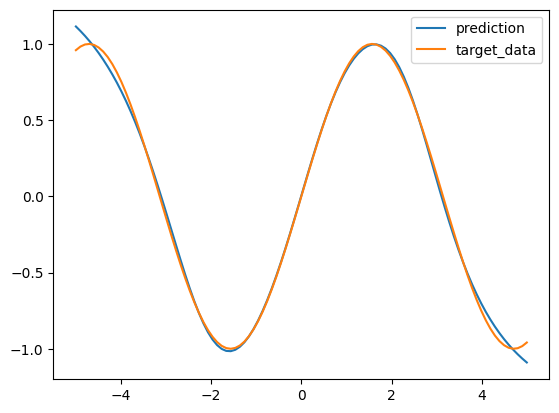

In [9]:
# 학습 후 입력이 정답에 얼마나 가까워 졌는지 시각화 해보기
pred_ys = model.feed_forward(train_x)

plt.plot(train_x.ravel(), pred_ys.ravel(), label = 'prediction')
plt.plot(train_x.ravel(), train_y.ravel(), label = 'target_data')
plt.legend()

- plt.plot 함수를 이용해서 mini-batch를 사용한 stochastic gradient descent의 경우, error가 어떻게 줄어드는지 확인해봅시다.
- full-batch gradient descent를 사용한 경우와 plot을 통해 비교를 해보면 차이를 좀 더 명확히 확인할 수 있습니다.
    - full-batch의 경우, 매 epoch마다 전체 dataset을 모두 사용하여 GD를 하기 때문에 그래프가 매끄럽지만, SGD에 비하여 초기 수렴속도가 느린 편입니다.
    - mini-batch의 경우, 매 epoch마다 mini-batch를 sampling해서 GD를 하기 때문에 그래프가 매끄럽지 않지만, 그만큼 초기에 빠르게 minimum으로 수렴하는 것을 확인할 수 있습니다.

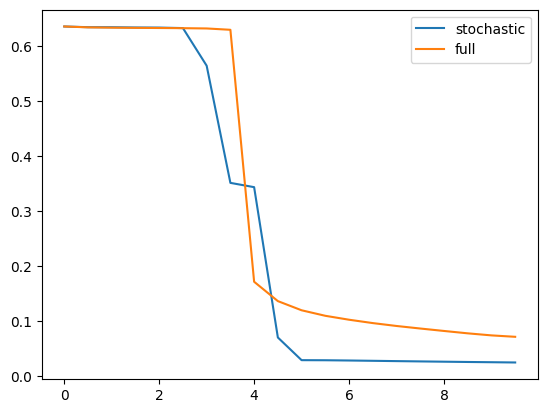

In [10]:
x_domain = np.arange(0.0, 10.0, 0.5)
plt.plot(x_domain, errors_stochastic, label = 'stochastic')
plt.plot(x_domain, errors_full, label = 'full')
plt.legend()